# Importing all the important libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, Metric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import os
import zipfile
import shutil
import random
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# Check if there's any available GPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)

tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Downloading the cars.zip

In [3]:
!wget --no-check-certificate \
  https://stanfordmedicine.box.com/shared/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip.\
  -O /tmp/cars.zip    # The link to the cars.zip

--2023-12-02 17:52:45--  https://stanfordmedicine.box.com/shared/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip.
Resolving stanfordmedicine.box.com (stanfordmedicine.box.com)... 74.112.186.144
Connecting to stanfordmedicine.box.com (stanfordmedicine.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip. [following]
--2023-12-02 17:52:45--  https://stanfordmedicine.box.com/public/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip.
Reusing existing connection to stanfordmedicine.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://stanfordmedicine.app.box.com/public/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip. [following]
--2023-12-02 17:52:46--  https://stanfordmedicine.app.box.com/public/static/1onms226m6z9oyzsgqjn93h80rqyeqhq.zip.
Resolving stanfordmedicine.app.box.com (stanfordmedicine.app.box.com)... 74.112.186.144
Connecting to stanfordmedic

# Unzip and read cars.zip, then preprocess image data with ImageDataGenerator()


In [4]:
local_zip = '/tmp/cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')   # Unzip and read the file
zip_ref.extractall('/tmp')
zip_ref.close()                             # Close the zip file

base_path = '/tmp/cars'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BMW', 'Lamborghini', 'McLaren', 'Bugatti', 'Volkswagen'], batch_size=10)  # Training set
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BMW', 'Lamborghini', 'McLaren', 'Bugatti', 'Volkswagen'], batch_size=10)  # Cross validation set
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BMW', 'Lamborghini', 'McLaren', 'Bugatti', 'Volkswagen'], batch_size=10, shuffle=False)  # Test set

imgs, labels = next(train_batches)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


# Display 10 images to make sure right images are imported

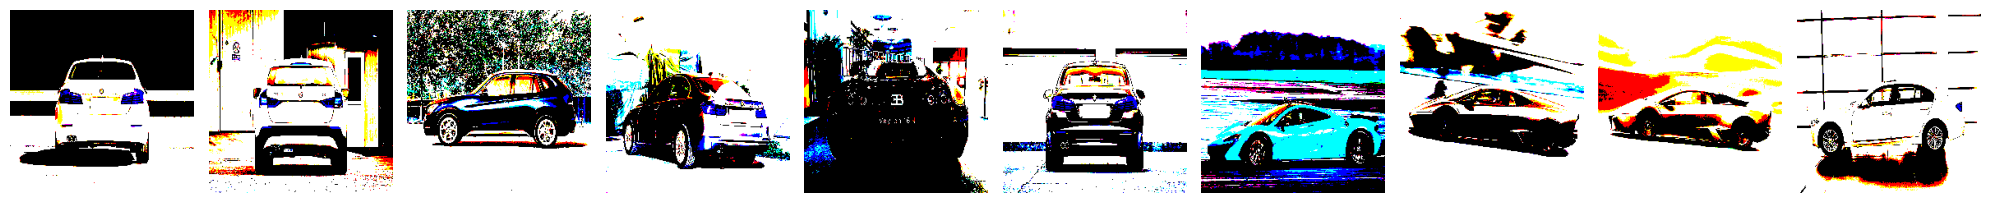

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)    # Show the preprocess image data
print(labels)       # Show the labels of the class

# Download and utilized pre-trained VGG16 convoluntional neural network

In [6]:
vgg16_model = tf.keras.applications.vgg16.VGG16()   # Download VGG16
vgg16_model.summary()   # Display VGG16 hidden layers

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Copy VGG16 hidden layer and remove the output layer

In [7]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)  # Copy the whole model except the last output layer

model.summary()   # Display the copied VGG16 layers with output of 5 classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# Freeze hidden layers and add in the 5 classes of output

In [8]:
for layer in model.layers:
    layer.trainable = False   # Freeze the hidden layers and utilize the foward propagation

model.add(Dense(units=5, activation='softmax'))   # Add in the 5 classes of output
model.summary()   # Display the current VGG16 layers with output of 5 classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# Start running foward propagation with 10 iterations

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
40/40 - 10s - loss: 1.7530 - accuracy: 0.3175 - val_loss: 1.3724 - val_accuracy: 0.4700 - 10s/epoch - 253ms/step
Epoch 2/10
40/40 - 3s - loss: 1.0977 - accuracy: 0.5650 - val_loss: 1.0588 - val_accuracy: 0.5700 - 3s/epoch - 74ms/step
Epoch 3/10
40/40 - 3s - loss: 0.8332 - accuracy: 0.6525 - val_loss: 0.9057 - val_accuracy: 0.6500 - 3s/epoch - 73ms/step
Epoch 4/10
40/40 - 4s - loss: 0.6740 - accuracy: 0.7375 - val_loss: 0.7989 - val_accuracy: 0.6500 - 4s/epoch - 88ms/step
Epoch 5/10
40/40 - 3s - loss: 0.5566 - accuracy: 0.8100 - val_loss: 0.7181 - val_accuracy: 0.7000 - 3s/epoch - 74ms/step
Epoch 6/10
40/40 - 3s - loss: 0.4811 - accuracy: 0.8600 - val_loss: 0.6593 - val_accuracy: 0.7100 - 3s/epoch - 76ms/step
Epoch 7/10
40/40 - 4s - loss: 0.4141 - accuracy: 0.8725 - val_loss: 0.6173 - val_accuracy: 0.7300 - 4s/epoch - 98ms/step
Epoch 8/10
40/40 - 3s - loss: 0.3644 - accuracy: 0.9100 - val_loss: 0.5770 - val_accuracy: 0.7700 - 3s/epoch - 75ms/step
Epoch 9/10
40/40 - 3s - loss:

# Plot the confusion matrix of true vs predicted

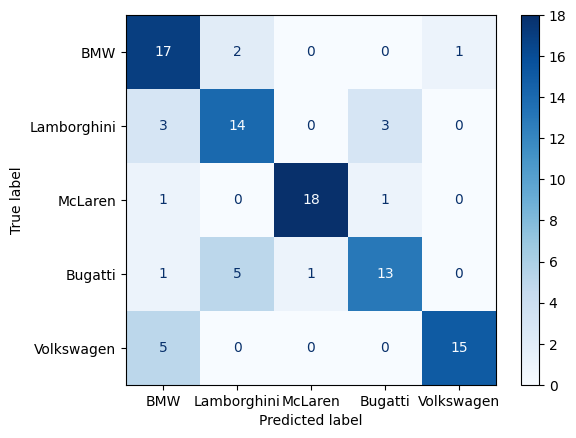

In [10]:
y_test = test_batches.classes
output_layer = model.predict(x=test_batches, verbose=0)
y_pred = np.argmax(output_layer, axis=-1)

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BMW', 'Lamborghini', 'McLaren', 'Bugatti', 'Volkswagen'])
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Modify and fine-tune VGG16 to fit to our case

In [11]:
# Checking the VGG16 model
vgg16_modified_model = tf.keras.applications.vgg16.VGG16()

# Copy the whole model except the last output layer and freeze the weight of the hidden layers
modified_model = Sequential()
for layer in vgg16_modified_model.layers[:-1]:
    modified_model.add(layer)

modified_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

# Adding in regularization layers



In [12]:
# Regularization techniques
modified_model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
modified_model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
modified_model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
modified_model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
modified_model.add(Dense(name='predictions', units=5, activation='softmax'))
modified_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

# Unfreeze the last block of the model and train the weights

In [13]:
# First unfreeze all the hidden layers
for layer in modified_model.layers:
    layer.trainable = True

# Freeze first four convolution blocks
for layer in modified_model.layers[:14]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(modified_model.layers):
    print(i, layer.name, layer.trainable)


0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False
3 block2_conv1 False
4 block2_conv2 False
5 block2_pool False
6 block3_conv1 False
7 block3_conv2 False
8 block3_conv3 False
9 block3_pool False
10 block4_conv1 False
11 block4_conv2 False
12 block4_conv3 False
13 block4_pool False
14 block5_conv1 True
15 block5_conv2 True
16 block5_conv3 True
17 block5_pool True
18 flatten True
19 fc1 True
20 fc2 True
21 dense_1 True
22 dense_2 True
23 dense_3 True
24 dense_4 True
25 predictions True


# Use F1 score as the new evaluation metrics

In [14]:
# Define F1 score as a custom metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.round(y_true)
        y_pred = K.round(y_pred)

        true_positives = K.sum(K.cast(y_true * y_pred, K.floatx()))
        false_positives = K.sum(K.cast((1 - y_true) * y_pred, K.floatx()))
        false_negatives = K.sum(K.cast(y_true * (1 - y_pred), K.floatx()))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())

        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1

# Introduce Early Stopping and train the model

In [15]:
modified_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
modified_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)


Epoch 1/20
40/40 - 9s - loss: 1.2006 - accuracy: 0.6225 - f1_score: 0.5952 - val_loss: 0.6168 - val_accuracy: 0.8200 - val_f1_score: 0.8187 - 9s/epoch - 224ms/step
Epoch 2/20
40/40 - 5s - loss: 0.6105 - accuracy: 0.8975 - f1_score: 0.8903 - val_loss: 0.5947 - val_accuracy: 0.8700 - val_f1_score: 0.8629 - 5s/epoch - 113ms/step
Epoch 3/20
40/40 - 4s - loss: 0.4365 - accuracy: 0.9475 - f1_score: 0.9521 - val_loss: 1.2615 - val_accuracy: 0.7200 - val_f1_score: 0.7107 - 4s/epoch - 110ms/step
Epoch 4/20
40/40 - 5s - loss: 0.3986 - accuracy: 0.9425 - f1_score: 0.9449 - val_loss: 0.6391 - val_accuracy: 0.8800 - val_f1_score: 0.8788 - 5s/epoch - 128ms/step
Epoch 5/20
40/40 - 4s - loss: 0.3543 - accuracy: 0.9700 - f1_score: 0.9673 - val_loss: 0.7702 - val_accuracy: 0.8700 - val_f1_score: 0.8744 - 4s/epoch - 112ms/step
Epoch 6/20
40/40 - 4s - loss: 0.2744 - accuracy: 0.9825 - f1_score: 0.9825 - val_loss: 0.9969 - val_accuracy: 0.8600 - val_f1_score: 0.8600 - 4s/epoch - 110ms/step
Epoch 7/20
40/40

# Plot the confusion matrix of true vs predicted

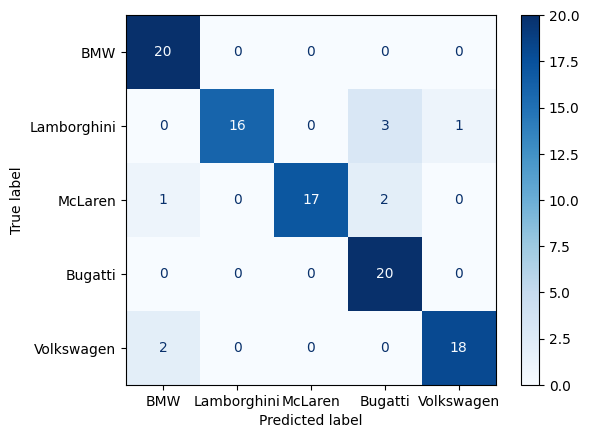

In [16]:
modified_y_test = test_batches.classes
modified_output_layer = modified_model.predict(x=test_batches, verbose=0)
modified_y_pred = np.argmax(modified_output_layer, axis=-1)

cm = confusion_matrix(modified_y_test, modified_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BMW', 'Lamborghini', 'McLaren', 'Bugatti', 'Volkswagen'])
disp.plot(cmap=plt.cm.Blues)

plt.show()